In [1]:
import os
import numpy as np
import pandas as pd

In [2]:
ls

behav.txt                     fszstatcope2_means_nz.csv
bild_roi_analysis.ipynb       fszstatcope2_nvoxels_all.csv
fszstatcope2_means_all.csv    fszstatcope2_nvoxels_nz.csv


## loading and preprocessing data

In [3]:
voxels = pd.read_csv("fszstatcope2_nvoxels_nz.csv", index_col=0)
behav = pd.read_csv("behav.txt", sep='\t', index_col=0)
print(np.mean(behav.index == voxels.index)) #should be 1.0
voxels_g27 = voxels.iloc[:, (voxels.iloc[1,:] > 27).values]
remove_feature_idx = []

for idx, col in enumerate(voxels_g27.columns):
    for ss in ["Vent", "Stem", "Cerebellum", "CSF", "White", "plexus"]:
        if ss in col:
            remove_feature_idx.append(idx)
            
remove_feature_idx = np.unique(remove_feature_idx)
print(voxels_g27.shape[1] - remove_feature_idx.shape[0]) # should be 58
voxels_data = voxels_g27.iloc[:, np.setdiff1d(np.arange(voxels_g27.shape[1]), remove_feature_idx)]
roi_data = pd.read_csv("fszstatcope2_means_nz.csv", index_col=0).loc[:, voxels_data.columns]
print(np.all(roi_data.columns == voxels_data.columns)) # should be true

1.0
58
True


## removing linear effect of covaries from roi data

In [4]:
def projection(data , covars):
    """for removing linear effect of covariates"""
    X, C = data.values, covars.values
    P = np.eye(C.shape[0]) - C.dot(np.linalg.pinv(C.T.dot(C))).dot(C.T)
    return pd.DataFrame(P.dot(X), columns=data.columns, index=data.index)

data = projection(roi_data, behav.loc[:, ["gender", "iq", "outliers", "composite_motion"]])

## unsupervised dimensionality reduction visualization

conclusion: this says nothing

In [5]:
% matplotlib inline
import matplotlib.pyplot as plt
from sklearn import manifold
import seaborn as sns

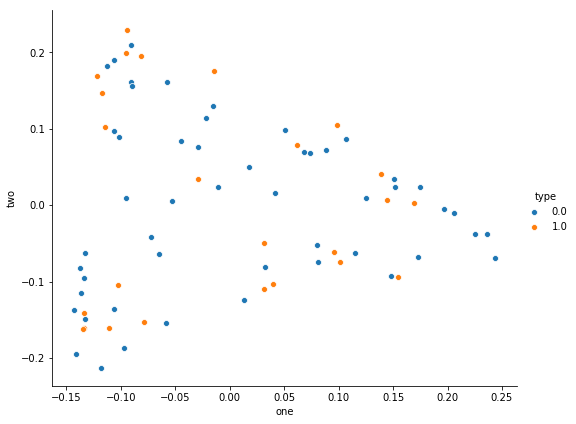

In [6]:
X_r, err = manifold.locally_linear_embedding(
    data.values, n_neighbors=6, n_components=2
)

ax=sns.pairplot(
    x_vars=["one"], 
    y_vars=["two"], 
    data=pd.DataFrame(np.hstack((X_r, behav["young_kid"].values[:, None])), columns=["one", "two", "type"]), 
    hue="type",
    height=6, aspect=10/8.27
)


## quick first pass to see what the accuracy is - using all the data & overfitting

In [7]:
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score

In [8]:
clf = Pipeline([
    ("scale", StandardScaler()),
    ("lg", linear_model.LogisticRegression())
])

clf.fit(data.values, behav.young_kid.values)

print("overfitting, all data classification score: {} % correct".format(
    round(roc_auc_score(behav.young_kid.values, clf.predict(data.values))*100, 3)
))

overfitting, all data classification score: 80.039 % correct


## now overfitting using l1 regularization

In [9]:
clf = Pipeline([
    ("scale", StandardScaler()),
    ("lg", linear_model.LogisticRegression(
        penalty="l1",
        solver="liblinear"
    ))
])

clf.fit(data.values, behav.young_kid.values)

print("overfitting, all data classification score: {} % correct\n".format(
    round(roc_auc_score(behav.young_kid.values, clf.predict(data.values))*100, 3)
))

print("columns selected:")
for idx, col in enumerate(data.columns.values[(clf.named_steps["lg"].coef_ != 0).ravel()]):
    print(idx+1, col)

overfitting, all data classification score: 78.039 % correct

columns selected:
1 ctx_lh_G_temp_sup-G_T_transv.nii.gz
2 Left-Accumbens-area.nii.gz
3 ctx_rh_G_oc-temp_med-Parahip.nii.gz
4 Right-Accumbens-area.nii.gz
5 ctx_rh_G_temp_sup-Lateral.nii.gz
6 Left-Putamen.nii.gz
7 ctx_lh_S_collat_transv_ant.nii.gz
8 ctx_lh_Lat_Fis-post.nii.gz
9 ctx_lh_G_temp_sup-Plan_polar.nii.gz
10 ctx_rh_G_and_S_cingul-Ant.nii.gz
11 ctx_rh_S_temporal_sup.nii.gz
12 ctx_rh_Lat_Fis-post.nii.gz
13 Right-Amygdala.nii.gz
14 ctx_rh_G_postcentral.nii.gz
15 Left-Thalamus-Proper.nii.gz
16 ctx_rh_G_front_middle.nii.gz
17 ctx_lh_G_temporal_inf.nii.gz
18 ctx_rh_S_collat_transv_ant.nii.gz
19 ctx_rh_G_temporal_inf.nii.gz
20 ctx_rh_G_front_inf-Orbital.nii.gz
21 ctx_rh_G_precentral.nii.gz
22 ctx_rh_S_pericallosal.nii.gz
23 Left-Caudate.nii.gz
24 ctx_rh_S_front_middle.nii.gz
25 ctx_rh_S_oc-temp_med_and_Lingual.nii.gz
26 Right-Hippocampus.nii.gz
27 ctx_rh_G_temp_sup-G_T_transv.nii.gz
28 ctx_lh_S_suborbital.nii.gz


## rationale for why chance is not 50% for unbalanced classes, though I think ROC gets over this problem

chance level is the probability of a random classifier picking the majority class, here this is $y = 1 = {51\over{76}} \approx 0.67$: 

$$P(chance) = P(\hat y = 1)P(y = 1) + P(\hat y = 0)P(y = 0)$$

according to this dataset: 

$$P(y = 1) \approx 0.671$$

$$P(y = 0) \approx 0.3289$$

so: 

$$P(\hat y = 1)P(y = 1) + P(\hat y = 0) + P(y = 0)$$

$$\approx 0.67\times0.67 + 0.67\times0.33$$

$$\approx 0.67$$

## can group status be predicted using just the hippocampi rois

In [110]:
from sklearn import svm
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import ShuffleSplit, LeaveOneOut
from sklearn import metrics
from sklearn.model_selection import permutation_test_score

In [112]:
clf = Pipeline([
    ("scale", StandardScaler()),
    ("svc", svm.SVC(
        kernel="rbf"
    ))
])

X = data.loc[:, ["Right-Hippocampus.nii.gz", "Left-Hippocampus.nii.gz"]].values
y = behav["young_kid"].values

pred_scores = np.zeros(X.shape[0])
predicted = np.zeros(X.shape[0])
true_class = np.zeros(X.shape[0])

for idx, (train_idx, test_idx) in enumerate(LeaveOneOut().split(X)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    clf.fit(X_train, y_train)
    predicted[idx], true_class[idx] = clf.predict(X_test), y_test
    pred_scores[idx] = np.int64(predicted[idx] == true_class[idx])

print(pred_scores.mean())

0.6710526315789473


In [127]:
score, permutation_scores, pvalue = permutation_test_score(
    clf, X, y, scoring="accuracy", cv=LeaveOneOut(), n_permutations=10000, n_jobs=1
)

Text(0.5,0,'Score')

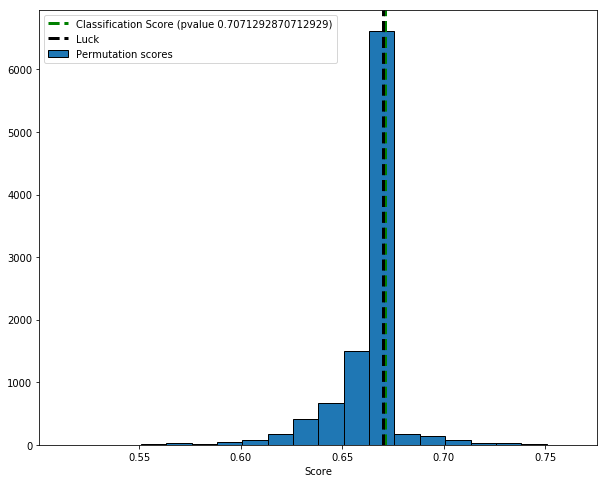

In [132]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 8

plt.hist(permutation_scores, 20, label='Permutation scores', edgecolor='black')
ylim = plt.ylim()
plt.plot(2 * [score], ylim, '--g', linewidth=3, label='Classification Score (pvalue %s)' % pvalue)
plt.plot([.67, .67], ylim, '--k', linewidth=3, label='Luck')
plt.ylim(ylim)
plt.legend()
plt.xlabel('Score')

# using a "smarter" strategy - using leaveoneout cv and shuffle split resampling stratified to 50/50 class labels

In [235]:
def evensplit_resampler(y, n_resamples):
    N, shuff_idx = y.shape[0], []
    if N % 2 == 0:
        class_one_N, class_two_N = N/2, N/2
    else:
        class_one_N = np.floor(N/2)
        class_two_N = N - class_one_N
    for idx in np.arange(n_resamples):
        class_one_idx, class_two_idx = np.where(y == 1)[0], np.where(y == 0)[0]
        idxs = np.array([
            np.random.choice(class_one_idx, size=int(class_one_N), replace=True),
            np.random.choice(class_two_idx, size=int(class_two_N), replace=True)
        ]).ravel()
        for shuff_iter in np.arange(10):
            np.random.shuffle(idxs)
        shuff_idx.append(idxs)
    return shuff_idx

In [250]:
cv_idxs = evensplit_resampler(y, 10000)

In [251]:
clf = Pipeline([
    ("scale", StandardScaler()),
    ("svc", svm.SVC(
        kernel="rbf"
    ))
])

accs = np.zeros(len(cv_idxs))

for outer_idx, cidx in enumerate(cv_idxs):
    X_resampled, y_resampled = X[cidx], y[cidx]
    
    pred_scores = np.zeros(X.shape[0])
    predicted = np.zeros(X.shape[0])
    true_class = np.zeros(X.shape[0])
    
    for idx, (train_idx, test_idx) in enumerate(LeaveOneOut().split(X_resampled)):
        X_train, X_test = X_resampled[train_idx], X_resampled[test_idx]
        y_train, y_test = y_resampled[train_idx], y_resampled[test_idx]
        clf.fit(X_train, y_train)
        predicted[idx], true_class[idx] = clf.predict(X_test), y_test
        pred_scores[idx] = np.int64(predicted[idx] == true_class[idx])
    
    accs[outer_idx] = pred_scores.mean()

Text(0.5,0,'Score')

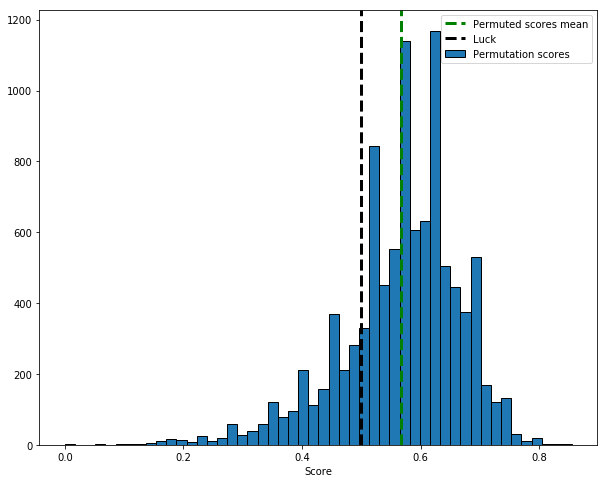

In [257]:
plt.hist(accs, bins=50, label='Permutation scores', edgecolor='black')
ylim = plt.ylim()
plt.plot(2 * [accs.mean()], ylim, '--g', linewidth=3, label="Permuted scores mean")
plt.plot([.5, .5], ylim, '--k', linewidth=3, label='Luck')
plt.ylim(ylim)
plt.legend()
plt.xlabel('Score')

In [255]:
np.mean(accs)

0.5661407894736843

## checking to see if the addition of quadratic features helps at all

In [266]:
X_poly2 = np.hstack((X, X**2))

accs = np.zeros(len(cv_idxs))

for outer_idx, cidx in enumerate(cv_idxs):
    X_resampled, y_resampled = X_poly2[cidx], y[cidx]
    
    pred_scores = np.zeros(X.shape[0])
    predicted = np.zeros(X.shape[0])
    true_class = np.zeros(X.shape[0])
    
    for idx, (train_idx, test_idx) in enumerate(LeaveOneOut().split(X_resampled)):
        X_train, X_test = X_resampled[train_idx], X_resampled[test_idx]
        y_train, y_test = y_resampled[train_idx], y_resampled[test_idx]
        clf.fit(X_train, y_train)
        predicted[idx], true_class[idx] = clf.predict(X_test), y_test
        pred_scores[idx] = np.int64(predicted[idx] == true_class[idx])
    
    accs[outer_idx] = pred_scores.mean()

Text(0.5,0,'Score')

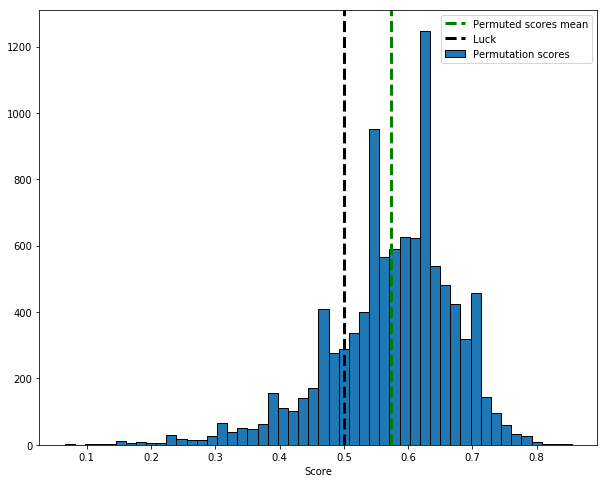

In [267]:
plt.hist(accs, bins=50, label='Permutation scores', edgecolor='black')
ylim = plt.ylim()
plt.plot(2 * [accs.mean()], ylim, '--g', linewidth=3, label="Permuted scores mean")
plt.plot([.5, .5], ylim, '--k', linewidth=3, label='Luck')
plt.ylim(ylim)
plt.legend()
plt.xlabel('Score')

In [278]:
print( "mean score: {mean_acc}\np-value if assuming the mean is the true score: {pval}".format(
    mean_acc=np.mean(accs),
    pval=(sum(accs >= np.mean(accs)) + 1) / (1*10e5)
))

mean score: 0.5740368421052632
p-value if assuming the mean is the true score: 0.005684
